# Project for 42186 Model-based Machine Learning F21  

## PGM in Intrusion Detection System

### Notebook - GMM (K=2)

The KDDCUP99 10 percent dataset from the UCI repository. [1] It is a benchmark dataset for the evaluation of network Intrusion Detection System including the records of normal and malicious traffics. It contains 494021 samples in total with 42 dimensions. 

The target for this project is to consider intrusion detection as a classification problem without time as parameter over the dataset. This notebook will study how to do a coarse-grained detection to classify the dataset samples into normal/abnormal by running GMM as an unsupervised learning model. 

[1] http://kdd.ics.uci.edu/databases/kddcup99/

# **Preparation**

Import required libraries Pyro:

In [ ]:
# Install Pyro, if necessary
!pip install pyro-ppl

     |████████████████████████████████| 634kB 30.0MB/s 


Mount the Google Drive to read the dataset later

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import the necessary packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, TraceEnum_ELBO, JitTrace_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDelta
from pyro import poutine

import torch
import torch.nn as nn

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

GPU provided by Colab is configured in this case to speed up the training process

In [ ]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:  
  device = torch.device('cuda:0')

print(USE_CUDA)
print(device)


True
cuda:0


In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
# monitor the GPU usage
from urllib.request import urlopen
exec(urlopen("http://colab-monitor.smankusors.com/track.py").read())
_colabMonitor = ColabMonitor().start()

Now live at : http://colab-monitor.smankusors.com/60ad260c4fffc


**Load the dataset from Drive**

Based on the printed statistics and information, the dataset contains 494021 samples in total with 42 dimensions, where the first 41 of them are the features of network traffic and the last dimension is the label to indicate whether the traffic is normal or not. The 41 features are collected by directly extracting from the network traffic flow like the src_bytes, or by computing with a two-second time window like the serror_rate. For these 41 features, they are in the form of continuous, discrete or symbolic with the ranges varying widely. 

In [ ]:
# load csv
data = pd.read_csv("/content/gdrive/My Drive/KDD/kddcup.data_10_percent_corrected", header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'])
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.0,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.285690,292.906557,0.176687,0.176609,0.057433,0.057719,0.791547,0.020982,0.028997,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,0.010551,0.007793,2.012718,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147412,246.322817,0.380717,0.381017,0.231623,0.232147,0.388189,0.082205,0.142397,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,511.000000,511.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

The dataset includes the traffic records with the normal traffics and 22 type of attacks. Among these records, only around 20% of the records are the normal ones and the rest 80% are the abnormal ones.

In [ ]:
proportions = data["type"].value_counts()
print(proportions)
normal_data_count = data["type"].loc[data["type"]=="normal."].value_counts()
print(normal_data_count)
print("Anomaly Percentage", normal_data_count / proportions.sum())

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: type, dtype: int64
normal.    97278
Name: type, dtype: int64
Anomaly Percentage normal.    0.196911
Name: type, dtype: float64


# **Preprocessing**

Data encoding:

To do the binary clustering, the label with different type of attacks need to be encoded into abnormal/normal. 

In [ ]:
# Encode the dataset label into binary format: abnormal (0)/normal (1)
data.loc[data["type"] != "normal.", 'type'] = 0
data.loc[data["type"] == "normal.", 'type'] = 1

In [ ]:
# check the binary encoding results

proportions = data["type"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[0] / proportions.sum())

0    396743
1     97278
Name: type, dtype: int64
Anomaly Percentage 0.8030893423558918


Since the featrues are saved in different format in the dataset and it's hard to process the features recorded as object. Thus, the one-hot encoding is done to these features to encode them into numerical values. 

In [ ]:
# One-hot encoding the data int numerical values

one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)
    
data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
data.head()

,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,...,SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,1


Featrue scaling:
 
Considering the features has different range, standardization is done to deal with this by keeping the values centered around the mean with a unit standard deviation.

In [ ]:
# Standardize the numeric variables

cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

Split the dataset:

Split the label out of the dataset into X and y. Split the X and y into trainset and testset with 66% of samples as trainset.

In [ ]:
# separate between features/inputs X and label/output variables y
mat = data.values
X = mat[:,0:-1]
print(X.shape)
y = mat[:,-1]
y = y.astype('int')
print(y.shape)


(494021, 118)
(494021,)


In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 326053
num test: 167968


# **Baseline model from sklearn**

Define the GMM from sklearn as the baseline model:

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2, covariance_type='spherical', random_state=0) # Several type of covariance_type are offered in sklearn GMM and "spherical" works the best here

gmm.fit(X_train)

# make predictions for test set
y_hat = gmm.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# Compute the general prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [1 0 0 ... 0 1 1]
true values: [0 0 0 ... 0 1 0]
Accuracy: 0.7256203562583349


To look into details on how the model performs, classification_report provided by sklearn is called here to present a detailed evaluation with metrics like precision, recall, f1-score for each class. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      0.66      0.79    134730
           1       0.42      1.00      0.59     33238

    accuracy                           0.73    167968
   macro avg       0.71      0.83      0.69    167968
weighted avg       0.89      0.73      0.75    167968



# **GMM Model Training & Evaluation**

**GMM model with 2 components**

In this notebook, the target is to do a coarse-grained binary clustering to label the samples in the dataset into 2 clusters, the components of Gaussian mixture is defined as $K=2$ with some tuned parameter. The generative process is: 



1. Draw $w$ which is a vector $(1 \times K)$ with probabilities of each class: $w \sim \operatorname{Dirichlet}\left(w_{0}=10\right)$
2. Draw the uncertainty value of the clusters: $\sigma \sim \operatorname{Lognormal}\left(\mu_{0}=0, \sigma_{0}=5\right)$
3. For each cluster $k$ in the clusters $k \in\{1, \ldots, K\}$ where $K=2$: 
  * Draw the mean value of the this cluster: $\mu_{k} \sim \operatorname{Normal}\left(\mu_{1}=0, \sigma_{1}=5\right)$

4. For each sample in the dataset $n \in\{1, \ldots, N\}$: 
  * Draw latent variable: $z_{n} \sim \operatorname{Cat}(w)$ 
  * Define $k=z_{n}$ generate the samples: $x_{n} \sim \operatorname{Normal}\left(\mu_{k}, \sigma\right)$

To implement the model, vectorization is done for the variable to optimize the performance in Pyro. This implementation refers to the Pyro guideline [2] and config_enumerate() handler in Pyro [3] is called here to enable the enumeration over the assignments in each iteration.

[2] Gaussian Mixture Model, https://pyro.ai/examples/gmm.html


[3] Inference with Discrete Latent Variables, http://pyro.ai/examples/enumeration.html

In [ ]:
K = 2  # Fixed number of components.

@config_enumerate
def gmm(data=None):
    D = data.shape[1]
    # Global variables
    weights = pyro.sample('weights', dist.Dirichlet(10 * torch.ones(K, device=device)))
    scale = pyro.sample('scale', dist.LogNormal(0., 5.)).to(device)
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(torch.zeros(D, device=device), 5.).to_event(1))
        assert locs.shape == (K, D)
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale).to_event(1),obs=data)

The speed of the learning process is tweaked by defining the learning rate and $\beta_{1}$ & $\beta_{2}$. To run the inference in Pyro, TraceEnum_ELBO is used here to enable the enumerations in parallel during the sampling from discrete latent states. 

In [ ]:
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

# transform the dataset to tensor
X_train_torch = torch.from_numpy(X_train.astype(np.float64)).float()
X_test_torch = torch.from_numpy(X_test.astype(np.float64)).float()

The auto guide AutoDelta is used to construct a MAP guide based on Delta distributions. SVI is configured for inference. Compared with MCMC, experiments on this dataset show that SVI can present reasonable convergence time. 

In [ ]:
pyro.clear_param_store()
guide = AutoDelta(poutine.block(gmm, expose=['weights', 'locs', 'scale']))
svi = SVI(gmm, guide, optim, loss=elbo)

Initialization is done first in the consideration of the GMM is prone to local mode. The optimal initail value is selected from a number of values by iterating the seeds. 

In [ ]:
# Initialize the variables to uniform.
def init_loc_fn(site):
    if site["name"] == "weights":
        return (torch.ones(K) / K).to(device)
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(gmm, expose=['weights', 'locs', 'scale']))
    svi = SVI(gmm, global_guide, optim, loss=elbo)
    return svi.loss(gmm, global_guide, data)

# Choose the best value among 8000 random initializations.
data = X_train_torch.to(device)
loss, seed = min((initialize(seed), seed) for seed in range(8000))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 1684, initial_loss = 66405064.0


In [ ]:
losses = []
n_steps = 5000
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, loss))

[0] ELBO: 66405064.0
[500] ELBO: 60472908.0
[1000] ELBO: 54878628.0
[1500] ELBO: 49302796.0
[2000] ELBO: 43943540.0
[2500] ELBO: 39104908.0
[3000] ELBO: 35270376.0
[3500] ELBO: 32651952.0
[4000] ELBO: 31098112.0
[4500] ELBO: 30301244.0


The inference comletes after 5000 steps. The plot below presents that the loss basically reaches a convergence. But the converged loss is relatively high, which also indicates that the model might get stuck in local optima. This can be happened due to the non-convex feature of the mixture model optimization process. 

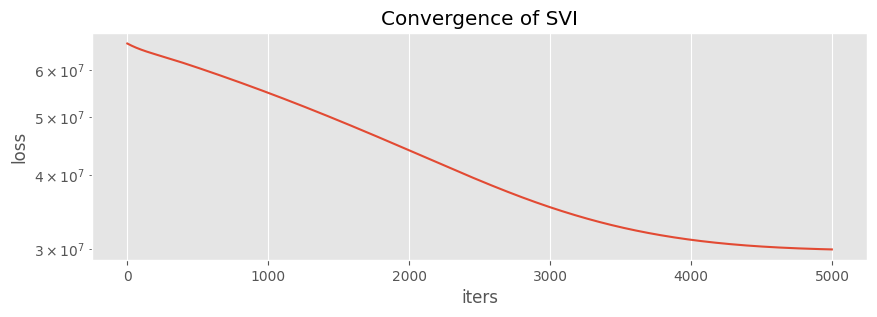

In [ ]:
from matplotlib import pyplot
%matplotlib inline

pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

**Model evaluation**

With a model trained by the trainset, the model is expected to be used to make prediction on the testset for evaluation. To do this, the classifier is built to predict the testset based on the discrete inference. Effect handlers of *trace*, *replay* and *infer_discrete* in Pyro is used here to build the classfier and read out the cluster assignment results from the model. The trace hanlder here records the relationships amongst different pyro primitives. Each node in the trace includes the name, input and output value of the site. [4]


[4] Trace, https://docs.pyro.ai/en/dev/poutine.html#trace

In [ ]:
guide_trace = poutine.trace(guide).get_trace(data)  # record the globals
trained_model = poutine.replay(gmm, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature, first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    print(trace)
    return trace.nodes["assignment"]["value"], trace.nodes["weights"]["value"], trace.nodes["locs"]["value"], trace.nodes["scale"]["value"]

print(classifier(X_test_torch.to(device)))

(tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([0.9899, 0.0101], grad_fn=<ExpandBackward>), tensor([[ 5.7627e-01,  3.8307e-01,  4.0636e-02,  7.5990e-05,  3.4915e-05,
          2.3695e-04,  7.0267e-04,  2.2103e-04,  1.9029e-04,  2.4022e-04,
          4.7372e-04,  2.0660e-04,  2.5119e-04,  1.8256e-04,  1.1830e-02,
          2.3311e-04,  3.3056e-03,  5.7181e-01,  2.0294e-04,  2.9518e-04,
          1.3784e-03,  2.5620e-04,  9.3091e-03,  2.0655e-04,  2.1791e-04,
          1.2966e-01, -3.3897e-02,  2.5226e-04,  2.3167e-04,  2.3447e-04,
          1.9680e-04,  2.0897e-04,  2.0648e-04,  2.1372e-04,  2.1161e-04,
          2.4008e-04,  3.0294e-01,  2.3075e-04,  2.0389e-04,  1.8731e-04,
          2.1691e-04,  1.8473e-04,  7.9634e-04,  1.4205e-02, -4.5480e-08,
          1.8153e-04,  3.8915e-04,  2.5981e-04,  2.2520e-01,  3.2241e-06,
          2.1421e-04,  1.5062e-04,  2.3075e-04,  1.9504e-02,  1.8805e-04,
          2.3617e-04,  2.0501e-04,  2.1025e-04,  2.5256e-04,  9.1946e-04,
          3.0767e-06,  1.

In [ ]:
y_pred, y_weights, y_locs, y_scale = classifier(X_test_torch.to(device))
print(y_pred)

tensor([0, 0, 0,  ..., 0, 0, 0])


**Prediction results**

Detach the prediction results from GPU and make a general evalution on the accuracy by comparing the labels between the testset and prediction results. 

The accuracy shows an accuracy of 0.80 which is slighly higher than the baseline result 0.73 got from sklearn.

In [ ]:
y_pred = y_pred.detach().cpu().numpy() 
# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_pred == y_test) / len(y_test))

Accuracy: 0.8035459135073347


By taking a closer look at the prediction results for each cluster, the model implemented in Pyro also shows a better performance than the sklearn baseline model in general. Specifically, the model implemented in Pyro presents a more balanced detection capabilities with both relatively high precision in anomalous samples (0) and normal samples (1). But for the detection on normal samples, the recall and f1-score indicates that the model still need further tuning to yield more reliable detection results. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    134730
           1       0.72      0.01      0.02     33238

    accuracy                           0.80    167968
   macro avg       0.76      0.51      0.46    167968
weighted avg       0.79      0.80      0.72    167968



**Clustering parameters**

Below presents the parameters fitted for the GMM model trained in Pyro. The weights show that most of the data gathered in the component 0 (anomalous points) and others clustered to the component 1 (normal points).

In [ ]:
y_weights.cpu().detach().numpy()

array([0.98993826, 0.01006181], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


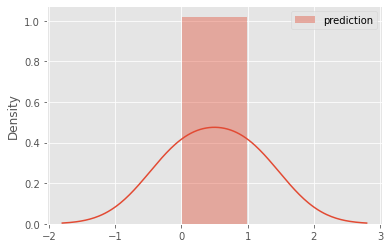

In [ ]:
sns.distplot(y_weights.cpu().detach().numpy(), label="prediction")
plt.legend()
plt.show()

The plot below is the density estimate and histogram of the mean values for the Gaussian distributions modeled for the samples of each component. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


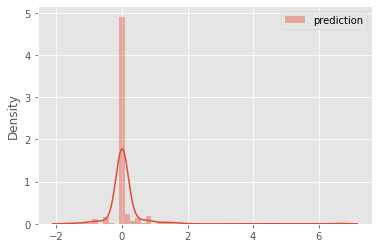

In [ ]:
sns.distplot(y_locs.cpu().detach().numpy(), label="prediction")
plt.legend()
plt.show()

To clearly compare the mixture model, the density estimate and histogram is drawn for both the real case (blue) and predicted case (red). In general, they show a similar pattern with two peaks. But it still presents some deviations from the real case. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


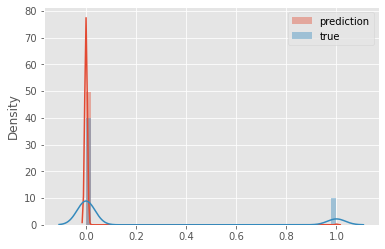

In [ ]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_test, label="true")
plt.legend()
plt.show()